# 5.2 - Generating MIDI music with an LSTM (no fluidsynth version)

This tutorial shows you how to generate musical notes using an LSTM. You will train a model using a dataset of MIDI files. Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate longer sequences of notes by calling the model repeatedly.

This tutorial is divided in 6 sections:
- **1 - Download the dataset:** You can download either the MAESTRO piano dataset, the Groove MIDI drums dataset, or the Lakh songs dataset. If you prefer, you can use your own MIDI dataset.
- **2 – Processing MIDI files:** We use the `pretty_midi` library to load the MIDI files into python. Then we can listen to the track and plot the MIDI score. We convert the MIDI files into the `notes` format, which includes pitch, velocity, note duration and step information.
- **3 - Create the training dataset:** We create a training dataset of only a few files (5) in the `notes` format.
- **4 - Create and train the model:** We create an LSTM that receives a sequence of 25 notes (with pitch, step, duration and velocity) and outputs the next note (also with pitch, step, duration and velocity). We train the model for 50 epochs.
- **5 - Generate notes and convert to MIDI:** We use the trained model to generate 120 predictions in the `note` format. We convert the predictions to MIDI and synthesise the result with `fluidsynth`.

**This is the notebook version without fluidsynth. To listen to the MIDI files, open them in VLC (https://www.videolan.org/vlc/) or in your preferred DAW.**

## 0 – Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files

In [8]:
!pip install pretty_midi
!pip install bokeh==2.4.1
!pip install visual_midi
!pip install git+https://github.com/craffel/pretty-midi --no-cache-dir # fixes np.int bug with numpy >1.20


  Using cached pretty_midi-0.2.9-py3-none-any.whl
  Cloning https://github.com/craffel/pretty-midi to /private/var/folders/xf/y0yb8j3d5cdc9fs6prv5ht2h0000gn/T/pip-req-build-tdkcrgg4
  Running command git clone --filter=blob:none --quiet https://github.com/craffel/pretty-midi /private/var/folders/xf/y0yb8j3d5cdc9fs6prv5ht2h0000gn/T/pip-req-build-tdkcrgg4
  Resolved https://github.com/craffel/pretty-midi to commit c510b12270b2a62daa7a30af58fd33288e0feffd
  Preparing metadata (setup.py) ... done


In [2]:
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import os
from visual_midi import Plotter
import pathlib
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

2023-02-10 10:29:23.927466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1 - Download the dataset
Here are three MIDI datasets available for you to experiment with:
- The [MAESTRO](https://magenta.tensorflow.org/datasets/maestro) dataset [[1]](#1) by Google Magenta: ~200 hours of virtuosic piano performances.
- The [Groove MIDI](https://magenta.tensorflow.org/datasets/groove) dataset [[2]](#2) by Google Magenta: 13.6 hours of aligned MIDI of human-performed, tempo-aligned expressive drumming.
- The [Lakh MIDI](https://colinraffel.com/projects/lmd/#get) dataset [[3]](#3) by C. Raffel: 176,581 unique MIDI files from songs, 45,129 of which have been matched and aligned to entries in the Million Song Dataset. [[4]](#4)

<a id="1">[1]</a> 
Curtis Hawthorne, Andriy Stasyuk, Adam Roberts, Ian Simon, Cheng-Zhi Anna Huang,
  Sander Dieleman, Erich Elsen, Jesse Engel, and Douglas Eck. "Enabling
  Factorized Piano Music Modeling and Generation with the MAESTRO Dataset."
  In International Conference on Learning Representations, 2019.<br/>
<a id="2">[2]</a> 
Jon Gillick, Adam Roberts, Jesse Engel, Douglas Eck, and David Bamman.
"Learning to Groove with Inverse Sequence Transformations."
  International Conference on Machine Learning (ICML), 2019.<br/>
<a id="3">[3]</a> 
Colin Raffel. "Learning-Based Methods for Comparing Sequences, with Applications to Audio-to-MIDI Alignment and Matching". PhD Thesis, 2016.<br/>
<a id="4">[4]</a> 
Bertin-Mahieux, T., Ellis, D. P. W., Whitman, B., & Lamere, P. (2011). The Million Song Dataset. Proceedings of the 12th International Society for Music Information Retrieval Conference. ISMIR, Miami, Florida. https://doi.org/10.7916/D8NZ8J07<br/>


In [3]:
# < ---- choose the dataset you will use here ---- >
dataset_name = 'groove' # 'groove' or 'maestro' or 'lakh
#< ------------------------------------------------- >

if dataset_name == 'groove':
    data_dir = pathlib.Path('data/groove')
    data_link = "https://storage.googleapis.com/magentadata/datasets/groove/groove-v1.0.0-midionly.zip"
    fname =  'groove-v1.0.0-midionly.zip'
    fname_glob = '/*/*/*.mid*'
    datasheet_fname = "data/groove/info.csv"
elif dataset_name == 'maestro': 
    data_dir = pathlib.Path('data/maestro-v2.0.0')
    data_link = "https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip"
    fname = 'maestro-v2.0.0-midi.zip'
    fname_glob ='/**/*.mid*'
    datasheet_fname ="data/maestro-v2.0.0/maestro-v2.0.0.csv"
elif dataset_name == 'lakh':
    data_dir = pathlib.Path('data/clean_midi')
    data_link = 'http://hog.ee.columbia.edu/craffel/lmd/clean_midi.tar.gz'
    fname = 'clean_midi.tar.gz'
    fname_glob = '/*/*.mid*'
    datasheet_fname = None
    

In [4]:
# download the desired dataset

if not data_dir.exists(): # if dataset is not already downloaded
    print('Downloading data...')
    tf.keras.utils.get_file(
        fname,
        origin=data_link,
        extract=True,
        cache_dir='.', cache_subdir='data',
    )
else:
    print(f"Dataset {dataset_name} already downloaded.")


if pathlib.Path(f"data/{fname}").exists():
    os.remove(f"data/{fname}") # remove zip file once extracted
  
filenames = glob.glob(str(data_dir)+fname_glob)
print('Number of files:', len(filenames))

Dataset groove already downloaded.
Number of files: 1150


In [5]:
# read datasheet 
if datasheet_fname is not None: 
    datasheet = pd.read_csv(datasheet_fname)
else: # lakh has no datasheet :(
    datasheet = None


## 2 – Processing MIDI files

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes.


In [6]:
sample_file = filenames[30] # pick a file
pm = pretty_midi.PrettyMIDI(sample_file) # generate a pretty_midi object for the sample file
print(sample_file)

# artist, title, style, composer ? let's match the file with the datasheet 
if dataset_name == 'maestro':
    item = datasheet.loc[datasheet['midi_filename']==sample_file.split('maestro-v2.0.0/')[-1]]
    print(f'Composer: {item["canonical_composer"].values[0]}\nTitle: {item["canonical_title"].values[0]}')
elif dataset_name == 'lakh':
    _, artist, title = sample_file.split('.')[0].split('/')[-3:]  # format in lakh dataset is data/artist/title.mid
    print(f'Artist: {artist}\nTitle: {title}')
elif dataset_name == 'groove':
    item = datasheet.loc[datasheet['midi_filename']==sample_file.split('groove/')[-1]]
    print(f'Style: {item["style"].values[0]}')


data/groove/drummer8/session2/21_afrobeat_110_beat_4-4.mid
Style: afrobeat


You can play the sample file by opening it with VLC.

Do some inspection on the MIDI file. What kinds of instruments are used?

In [7]:
print('Number of instruments:', len(pm.instruments))
for instrument in pm.instruments:
    if instrument.is_drum:
        instrument_name = 'Drums'
    else:
        instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

    print(instrument_name) # print the instrument MIDI names 

Number of instruments: 1
Drums


The LSTM we will use later can only train on one instrument. So we need to select only one instrument from the MIDI file:

In [8]:
instrument = pm.instruments[0]

### Extract `notes` with `midi_to_notes`

You will use three variables to represent a note when training the model: `pitch`, `step`, `duration` and `velocity`. The pitch corresponds to the frequency of the note and is associated to a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.
The `velocity` corresponds to the volume of each note.

The `midi_to_notes` conversion simply means that we convert from the MIDI format into a list of notes with their pitch, step and duration.


In [9]:
ROLAND_REDUCED_MAPPING = { # for the groove MIDI dataset
    "KICK": [36],
    "SNARE": [38, 37, 40],
    "HH_CLOSED": [42, 22, 44],
    "HH_OPEN": [46, 26],
    "TOM_3_LO": [43, 58],
    "TOM_2_MID": [47, 45],
    "TOM_1_HI": [50, 48],
    "CRASH": [49, 52, 55, 57],
    "RIDE":  [51, 53, 59]
}

def midi_to_notes(sample_file: str, instrument_idx=0) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(sample_file)
  instrument = pm.instruments[instrument_idx]
  notes = collections.defaultdict(list)
  
  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for i, note in enumerate(sorted_notes): 
    if dataset_name=='groove':
        for key, value in ROLAND_REDUCED_MAPPING.items(): # mapping used in the Groove MIDI dataset
            if note.pitch in value:
                note_name = key
    elif  instrument.is_drum:     
      note_name = pretty_midi.note_number_to_drum_name(note.pitch)
    else:
      note_name = pretty_midi.note_number_to_name(note.pitch)
   
    duration = note.end - note.start + 1 
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['name'].append(note_name)
    notes['velocity'].append(note.velocity)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(duration) 
    prev_start = start

  raw_notes = pd.DataFrame({name: np.array(value) for name, value in notes.items()})
  return raw_notes

raw_notes = midi_to_notes(sample_file, instrument_idx=0)
raw_notes.head()
    


,pitch,name,velocity,start,end,step,duration
0,36,KICK,70,0.014773,0.115909,0.000000,1.101136
1,51,RIDE,98,0.023864,0.125000,0.009091,1.101136
2,51,RIDE,42,0.276137,0.377273,0.252273,1.101136
3,44,HH_CLOSED,55,0.279546,0.380682,0.003409,1.101136
4,36,KICK,55,0.426137,0.527273,0.146591,1.101136


### Plot MIDI file

In [10]:
def plot_piano_roll(raw_notes):
    try:
        plotter = Plotter() 
        # load pretty_midi object from midi file 
        plotter.show_notebook(pm)
    except:  # if there's a tempo change in the file visual_midi won't load the plot 
        plt.figure(figsize=(20, 4))
        plot_pitch = np.stack([raw_notes['pitch'], raw_notes['pitch']], axis=0)
        plot_start_stop = np.stack([raw_notes['start'], raw_notes['end']], axis=0)
        plot_velocity = np.stack([raw_notes['velocity'], raw_notes['velocity']], axis=0)
        plt.plot(
            plot_start_stop, plot_pitch, color="b", marker=".")
        plt.xlabel('Time [s]')
        plt.ylabel('Pitch')
        
plot_piano_roll(raw_notes)


Loading BokehJS ...

Check the distribution of each note variable.

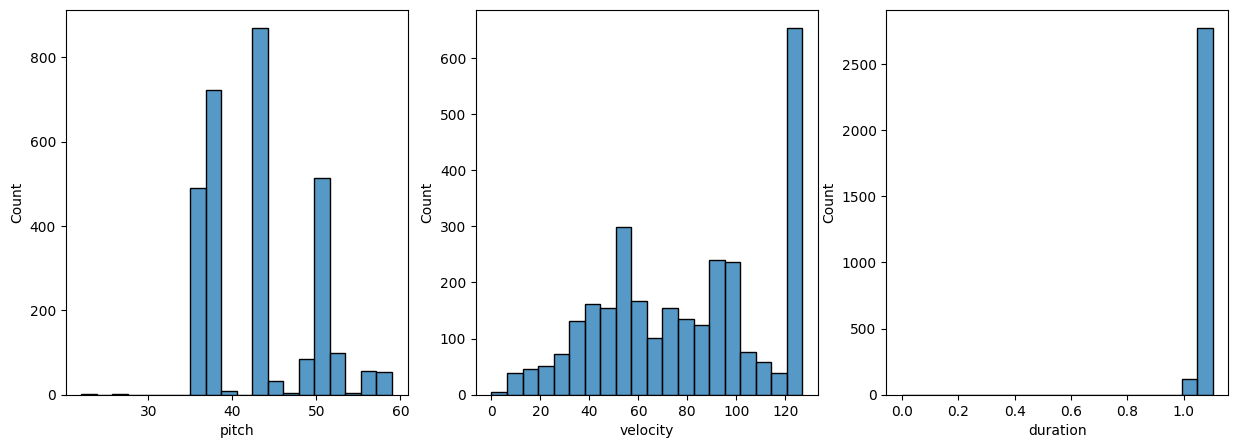

In [11]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['velocity'], 100 - drop_percentile)
  sns.histplot(notes, x="velocity", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))
  
plot_distributions(raw_notes)

### Convert from `notes` to a MIDI file with `notes_to_midi`

We can do the inverse conversion and convert the note values of `pitch`, `step`, `duration` and `velocity` into MIDI:

In [12]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  if instrument_name =='Drums':
      _instrument = pretty_midi.Instrument(program=1,is_drum=True)
  else:
    _instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=int(note['velocity']),
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    _instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(_instrument)
  pm.write(out_file)
  return pm

In the last section, we used `midi_to_note` to convert the `sample_file` (a MIDI file) into `notes`. Let's do now the inverse conversion, from `notes` to MIDI.

In [13]:
example_file = 'example.midi'
example_pm = notes_to_midi(raw_notes, out_file=example_file, instrument_name=instrument_name)

You can compare the generated MIDI file (after converting MIDI-->notes-->MIDI) with the original MIDI file. Open the following files in VLC:

In [14]:
print("Original file path:", sample_file)
print("Transformed file (MIDI-->notes-->MIDI) path:", example_file)

Original file path: data/groove/drummer8/session2/21_afrobeat_110_beat_4-4.mid
Transformed file (MIDI-->notes-->MIDI) path: example.midi


## 3 – Create the training dataset


Create the training dataset by converting the MIDI files to the `notes` format. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [15]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)
print('Number of notes parsed:', len(all_notes))

Number of notes parsed: 10225


Next, create a `tf.data.Dataset` from the parsed notes.

In [16]:
key_order = ['pitch', 'step', 'duration', 'velocity']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2023-02-10 10:29:45.739869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorSpec(shape=(4,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the ground truth. In this way, the model will be trained to predict the next note in a sequence. 

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [17]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch_and_velocity(x):
    x = x/[vocab_size, 1.0, 1.0, 128]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch_and_velocity(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). For the `lakh` and `maestro` datasets, the size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by MIDI. For the `groove` dataset, the vocabulary size is set to only the pitches used to represent every sound in the drum kit.

In [18]:
seq_length = 25

if dataset_name == 'groove': # drums don't use all 128 pitches so we need to reduce the vocab size
    drum_pitches = []
    for key, value in ROLAND_REDUCED_MAPPING.items():
        drum_pitches+=value
        vocab_size = len(set(drum_pitches)) # number of unique drum pitches
else: 
    vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=(25, 4), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'velocity': TensorSpec(shape=(), dtype=tf.float64, name=None)})

Batch the examples, and configure the dataset for performance.

In [19]:
batch_size = 64
buffer_size =  len(all_notes) - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

## 4 – Create and train the model

The model will have four outputs, one for each note variable (`pitch`, `step`, `duration` and `velocity`). For `step` and `duration`, you will use a custom loss function based on mean squared error (mse) that encourages the model to output non-negative values.

In [20]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [21]:
input_shape = (seq_length, 4)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
  'velocity': tf.keras.layers.Dense(128, name='velocity')(x),

}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
      'velocity':  tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 4)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          68096       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

Testing the `model.evaluate` function, you can see that the `pitch` and `velocity` losses are significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` and `velocity` losses.

In [22]:
losses = model.evaluate(train_ds, return_dict=True)
losses

159/159 [==============================] - 3s 11ms/step - loss: 11.3762 - duration_loss: 1.6075 - pitch_loss: 4.8736 - step_loss: 0.0080 - velocity_loss: 4.8872


{'loss': 11.376185417175293,
 'duration_loss': 1.6075096130371094,
 'pitch_loss': 4.873558521270752,
 'step_loss': 0.007958775386214256,
 'velocity_loss': 4.887159824371338}

One way balance this is to use the `loss_weights` argument to compile. The `loss` then becomes the weighted sum of the individual losses `loss = 0.05 * pitch_loss + 1 * step_loss + 1 * duration_loss + 0.05 * velocity_loss`

In [23]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
        'velocity': 0.05,
    },
    optimizer=optimizer,
)

model.evaluate(train_ds, return_dict=True)

159/159 [==============================] - 2s 8ms/step - loss: 2.1035 - duration_loss: 1.6075 - pitch_loss: 4.8736 - step_loss: 0.0080 - velocity_loss: 4.8872


{'loss': 2.1035053730010986,
 'duration_loss': 1.6075096130371094,
 'pitch_loss': 4.873558521270752,
 'step_loss': 0.007958775386214256,
 'velocity_loss': 4.887159824371338}

### Train the model

In [24]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [25]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
159/159 [==============================] - 5s 16ms/step - loss: 0.4257 - duration_loss: 0.0349 - pitch_loss: 2.6241 - step_loss: 0.0368 - velocity_loss: 4.4553
Epoch 2/50
159/159 [==============================] - 3s 16ms/step - loss: 0.3323 - duration_loss: 9.4136e-04 - pitch_loss: 2.1043 - step_loss: 0.0077 - velocity_loss: 4.3674
Epoch 3/50
159/159 [==============================] - 2s 15ms/step - loss: 0.3251 - duration_loss: 9.4695e-04 - pitch_loss: 1.9949 - step_loss: 0.0075 - velocity_loss: 4.3380
Epoch 4/50
159/159 [==============================] - 3s 16ms/step - loss: 0.3207 - duration_loss: 8.2220e-04 - pitch_loss: 1.9383 - step_loss: 0.0075 - velocity_loss: 4.3103
Epoch 5/50
159/159 [==============================] - 3s 16ms/step - loss: 0.3191 - duration_loss: 7.7799e-04 - pitch_loss: 1.9172 - step_loss: 0.0075 - velocity_loss: 4.2989
Epoch 6/50
159/159 [==============================] - 2s 15ms/step - loss: 0.3178 - duration_loss: 7.6301e-04 - pitch_loss: 1.901

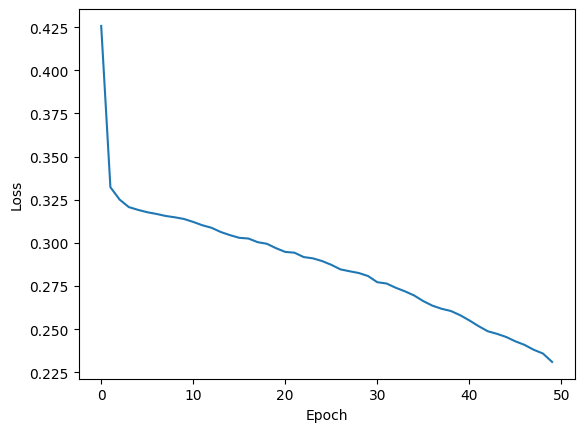

In [26]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

We only used 5 songs to train the model, so it is very likely that the model is overfitting to those songs, and that the generated song will be very similar to the training dataset. We did not use any validation dataset to avoid spending too much time training, but you can try adding a few songs for validation and plot both the training loss and validation loss.

## 5 - Generate notes and convert to MIDI

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch and velocity, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Always picking the note with the highest probability would lead to repetitive sequences of notes being generated. The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [27]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
  velocity_logits = predictions['velocity']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  velocity_logits /= temperature
  velocity = tf.random.categorical(velocity_logits, num_samples=1)
  velocity = tf.squeeze(velocity, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration), int(velocity)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [28]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1, 128]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration, velocity = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration, velocity)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 20ms/step


In [29]:
generated_notes.head(10)

,pitch,step,duration,velocity,start,end
0,38,0.087067,1.064077,101,0.087067,1.151144
1,44,0.159780,0.977376,98,0.246847,1.224223
2,49,0.141875,0.983814,65,0.388722,1.372537
3,38,0.162150,0.999779,126,0.550872,1.550651
4,37,0.145540,0.994952,71,0.696412,1.691364
5,36,0.151399,0.991734,76,0.847811,1.839545
6,26,0.148921,0.985593,80,0.996732,1.982325
7,38,0.153129,0.990240,57,1.149861,2.140101
8,44,0.187796,0.988411,122,1.337657,2.326068
9,36,0.173046,0.986083,62,1.510703,2.496786


You can listen to the generated MIDI file by opening it on VLC.

In [30]:
out_file = 'output.mid'
out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name=instrument_name)
print(f'Generated MIDI file saved to {out_file}.')

Generated MIDI file saved to output.mid.


Visualize the generated notes.

In [31]:
plot_piano_roll(generated_notes)

Loading BokehJS ...

Check the distributions of `pitch`, `step` and `duration`.

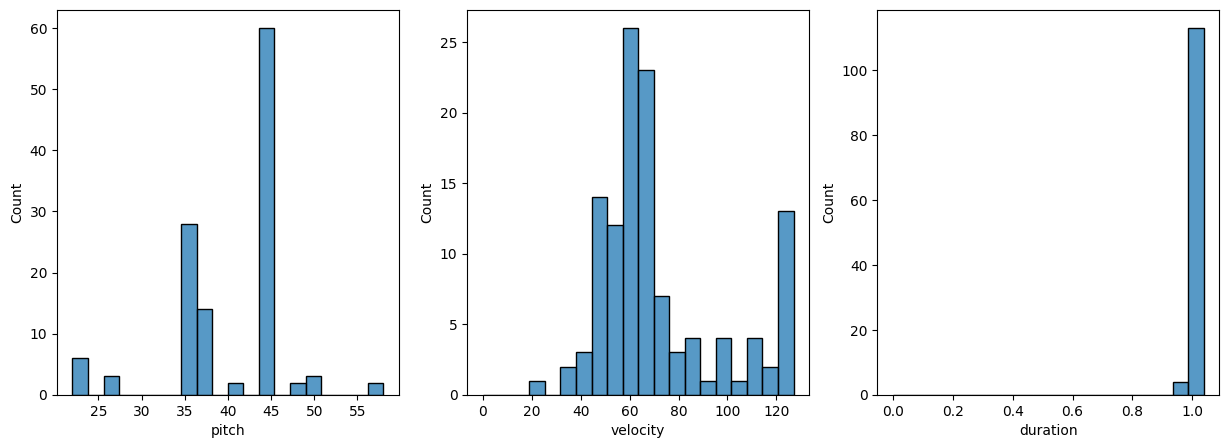

In [32]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. 
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


## A few extra questions

- Add code to listen to the training dataset (5 files) and compare it to the generated file. Do you identify any patterns the model is learning?
- Plot the distributions of the 5 training files and the 5 generated files. What differences do you observe? Is the model learning certain features (e.g., pitch) more than others (e.g., duration)
– In which context do you think a model like this could be useful? Consider the amount of time that it takes for the model to do inference. Is it suitable for real-time performances?

## Next steps

One of the alternatives to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).

## Credits
This notebook is based on the [Tensorflow Tutorial](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb), extended by Teresa Pelinski. I added support for the [Groove MIDI](https://magenta.tensorflow.org/datasets/groove) dataset and the [Lakh MIDI](https://colinraffel.com/projects/lmd/#get) dataset, and `visual_midi` for bokeh MIDI plots. I fixed note duration in `midi_to_notes`. Also added edits to deal with drum-only tracks as well as multi-instrument tracks, and added velocity prediction to the LSTM.

##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.